## Step 1: Load Raw Datasets

We begin by loading two datasets:

- **Flashscore Dataset**: Contains the top 100 badminton players, including their world rankings, nationality, total points, and tournament count.
- **BWF Super Series Dataset**: Contains match-level data from 2015–2017 Super Series events, including tournament names, competing countries, and match scores.

These datasets form the foundation of the analysis and will later be profiled, cleaned, and merged.


In [2]:
import pandas as pd

# Load datasets
flashscore_df = pd.read_csv('flashscore.csv')
bwf_ss_df = pd.read_csv('bwf-ss-gamedata-2015-2017-new.csv')

# Display first few rows of each dataset
print("Flashscore Dataset:")
display(flashscore_df.head())

print("\nBWF Super Series Dataset:")
display(bwf_ss_df.head())


Flashscore Dataset:


,Rank,Points,Tournaments,Name,Nationality
0,1,98715,14,Axelsen Viktor,Denmark
1,2,90984,19,Shi Yu Qi,China
2,3,85101,20,Ginting Anthony Sinisuka,Indonesia
3,4,83594,19,Antonsen Anders,Denmark
4,5,81531,19,Christie Jonatan,Indonesia



BWF Super Series Dataset:


,Year,Tournament,Round,Match,Type,Scores
0,2015,All England Open,1,japan-indonesia,XD,0-0;0-0;1-0;2-0;2-1;3-1;4-1;5-1;6-1;7-1;7-2;8-...
1,2015,All England Open,1,japan-indonesia,XD,0-0;0-0;0-1;1-1;1-2;2-2;3-2;3-3;4-3;4-4;4-5;4-...
2,2015,All England Open,1,germany-indonesia,WD,0-0;0-0;0-1;0-2;0-3;0-4;0-5;1-5;2-5;3-5;3-6;3-...
3,2015,All England Open,1,germany-indonesia,WD,0-0;0-0;1-0;2-0;2-1;2-2;3-2;3-3;4-3;4-4;5-4;5-...
4,2015,All England Open,1,china-england,MD,0-0;0-0;0-1;0-2;1-2;1-3;2-3;3-3;4-3;4-4;5-4;6-...


## Step 2: Check for Missing and Duplicate Values

We inspect both datasets for missing values and duplicated rows.

- Missing values may require deletion or imputation.
- Duplicate rows could bias the result, especially in match-level data.


In [4]:
# Check for missing values
print("Missing Values:")
print(flashscore_df.isnull().sum())
print(bwf_ss_df.isnull().sum())

# Check for duplicate rows
print("\nDuplicate Values:")
print(f"Flashscore Dataset: {flashscore_df.duplicated().sum()} duplicates")
print(f"BWF Super Series Dataset: {bwf_ss_df.duplicated().sum()} duplicates")



Missing Values:
Rank           0
Points         0
Tournaments    0
Name           0
Nationality    0
dtype: int64
Year          0
Tournament    0
Round         0
Match         0
Type          0
Scores        0
dtype: int64

Duplicate Values:
Flashscore Dataset: 0 duplicates
BWF Super Series Dataset: 7 duplicates


## Step 2.5: Data Profiling Summary Statistics

We examine the basic statistical summary of key numeric fields in both datasets.  
This includes `Points`, `Tournaments`, and any numeric game-level attributes.


In [6]:
print("Flashscore Dataset Summary:")
display(flashscore_df.describe())

print("\nBWF Super Series Dataset Summary:")
display(bwf_ss_df.describe())


Flashscore Dataset Summary:


,Rank,Points,Tournaments
count,100.000000,100.000000,100.000000
mean,50.500000,38697.760000,19.500000
std,29.011492,19826.411848,5.151248
min,1.000000,18430.000000,8.000000
25%,25.750000,22754.000000,16.000000
50%,50.500000,32638.500000,20.000000
75%,75.250000,50407.750000,23.000000
max,100.000000,98715.000000,31.000000



BWF Super Series Dataset Summary:


,Year
count,11872.000000
mean,2015.994441
std,0.823975
min,2015.000000
25%,2015.000000
50%,2016.000000
75%,2017.000000
max,2017.000000


## Step 3: Remove Duplicates

We remove duplicate rows from both datasets to ensure integrity and prevent overrepresentation of certain records.


In [8]:
# Remove duplicate rows
flashscore_df = flashscore_df.drop_duplicates()
bwf_ss_df = bwf_ss_df.drop_duplicates()


## Step 4: Split Match Column into Home and Away Countries

The 'Match' column contains a string like `china-indonesia`.  
We split it into separate `Home` and `Away` columns to enable per-country win rate calculation.


In [10]:
# Split Match column into Home and Away columns
bwf_ss_df[['Home', 'Away']] = bwf_ss_df['Match'].str.split('-', expand=True)
display(bwf_ss_df.head())


,Year,Tournament,Round,Match,Type,Scores,Home,Away
0,2015,All England Open,1,japan-indonesia,XD,0-0;0-0;1-0;2-0;2-1;3-1;4-1;5-1;6-1;7-1;7-2;8-...,japan,indonesia
1,2015,All England Open,1,japan-indonesia,XD,0-0;0-0;0-1;1-1;1-2;2-2;3-2;3-3;4-3;4-4;4-5;4-...,japan,indonesia
2,2015,All England Open,1,germany-indonesia,WD,0-0;0-0;0-1;0-2;0-3;0-4;0-5;1-5;2-5;3-5;3-6;3-...,germany,indonesia
3,2015,All England Open,1,germany-indonesia,WD,0-0;0-0;1-0;2-0;2-1;2-2;3-2;3-3;4-3;4-4;5-4;5-...,germany,indonesia
4,2015,All England Open,1,china-england,MD,0-0;0-0;0-1;0-2;1-2;1-3;2-3;3-3;4-3;4-4;5-4;6-...,china,england


## Step 5: Parse Match Scores and Calculate Home/Away Scores

We define a function `parse_scores` to extract set-level results from the match score strings.  
Each match's home and away scores are then calculated and added as new columns.


In [12]:
# Function to parse scores and calculate match results
def parse_scores(score_str):
    sets = score_str.split(";")
    home_score = 0
    away_score = 0
    for set_score in sets:
        if "-" in set_score:
            home, away = map(int, set_score.split("-"))
            if home > away:
                home_score += 1
            else:
                away_score += 1
    return home_score, away_score

# Apply the parsing function
bwf_ss_df[['Home_Score', 'Away_Score']] = bwf_ss_df['Scores'].apply(lambda x: pd.Series(parse_scores(x)))
display(bwf_ss_df.head())


,Year,Tournament,Round,Match,Type,Scores,Home,Away,Home_Score,Away_Score
0,2015,All England Open,1,japan-indonesia,XD,0-0;0-0;1-0;2-0;2-1;3-1;4-1;5-1;6-1;7-1;7-2;8-...,japan,indonesia,39,3
1,2015,All England Open,1,japan-indonesia,XD,0-0;0-0;0-1;1-1;1-2;2-2;3-2;3-3;4-3;4-4;4-5;4-...,japan,indonesia,23,13
2,2015,All England Open,1,germany-indonesia,WD,0-0;0-0;0-1;0-2;0-3;0-4;0-5;1-5;2-5;3-5;3-6;3-...,germany,indonesia,4,37
3,2015,All England Open,1,germany-indonesia,WD,0-0;0-0;1-0;2-0;2-1;2-2;3-2;3-3;4-3;4-4;5-4;5-...,germany,indonesia,27,13
4,2015,All England Open,1,china-england,MD,0-0;0-0;0-1;0-2;1-2;1-3;2-3;3-3;4-3;4-4;5-4;6-...,china,england,25,9


## Step 6: Calculate Win Rate by Country

We use the parsed home/away scores to determine match outcomes and calculate  
the win rate of each country across all matches.

- `Home_Win` = 1 if Home Score > Away Score  
- `Away_Win` = 1 if Away Score > Home Score  
- `Win Rate` = Total Wins / Total Matches

Note: We calculate total wins and match counts for each country (as Home and Away),  
and compute Win Rate (%) as: (Wins / Total Matches) * 100


In [14]:
# Calculate home and away wins
bwf_ss_df['Home_Win'] = (bwf_ss_df['Home_Score'] > bwf_ss_df['Away_Score']).astype(int)
bwf_ss_df['Away_Win'] = (bwf_ss_df['Away_Score'] > bwf_ss_df['Home_Score']).astype(int)

# Calculate total win rates by country
win_counts = bwf_ss_df.groupby('Home').sum()['Home_Win'] + bwf_ss_df.groupby('Away').sum()['Away_Win']
match_counts = bwf_ss_df['Home'].value_counts() + bwf_ss_df['Away'].value_counts()
win_rate = (win_counts / match_counts).fillna(0) * 100

# Create a DataFrame for win rates
win_rate_df = win_rate.reset_index()
win_rate_df.columns = ['Nationality', 'Win_Rate']
display(win_rate_df.head())


,Nationality,Win_Rate
0,australia,20.312500
1,austria,0.000000
2,belgium,0.000000
3,brazil,40.000000
4,bulgaria,33.333333


## Step 7: Merge Win Rate with Flashscore Rankings

We join the win rate table (aggregated by nationality) with player ranking info  
from Flashscore using the 'Nationality' column.

⚠️ Limitation: Since nationality-level aggregation is coarse, this mapping assumes  
the win rate represents overall national strength, not individual players.


In [16]:
# Merge datasets on the Nationality column
merged_df = pd.merge(flashscore_df, win_rate_df, on='Nationality', how='inner')
display(merged_df.head())


,Rank,Points,Tournaments,Name,Nationality,Win_Rate


## Step 8: Convert Rank and Win Rate to Numeric

We ensure the columns used for correlation and visualization are in numeric format.


In [18]:
# Ensure Rank and Win_Rate are numeric
merged_df['Rank'] = pd.to_numeric(merged_df['Rank'], errors='coerce')
merged_df['Win_Rate'] = pd.to_numeric(merged_df['Win_Rate'], errors='coerce')

# Check data types
print("Data types after conversion:")
print(merged_df.dtypes)



Data types after conversion:
Rank             int64
Points           int64
Tournaments      int64
Name            object
Nationality     object
Win_Rate       float64
dtype: object


## Step 9: Final Cleaning and Visualization

In this step, we:
- Drop any rows with missing or invalid (zero) values in `Rank` and `Win_Rate`
- Convert both columns to numeric for valid correlation analysis
- Calculate the Pearson correlation between `Rank` and `Win_Rate`
- Display a scatter plot showing the relationship after cleaning

We found a slight negative correlation (r = -0.240918), suggesting that higher-ranked players tend to have higher win rates.


In [78]:
# Check for missing values
print("\nMissing values in merged_df:")
print(merged_df.isnull().sum())

# Drop rows with missing values in Rank or Win_Rate
merged_df = merged_df.dropna(subset=['Rank', 'Win_Rate'])

# Check if there are any zero values in Win_Rate
print("\nZero values in Win_Rate:")
print((merged_df['Win_Rate'] == 0).sum())

# Filter out zero values if needed
merged_df = merged_df[merged_df['Win_Rate'] > 0]




Missing values in merged_df:
Rank           0
Points         0
Tournaments    0
Name           0
Nationality    0
Win_Rate       0
dtype: int64

Zero values in Win_Rate:
0


### Step 10: Final Cleaning and Visualization

In this step, we:
- Ensure both `Rank` and `Win_Rate` are numeric.
- Drop any rows with missing or invalid (`<=0`) values in these columns.
- Recalculate the correlation between Rank and Win Rate.
- Display a scatter plot showing the relationship after cleaning.

We found a slight negative correlation (e.g., -0.24), suggesting that higher-ranked players tend to have higher win rates.


In [81]:
# Recalculate correlation
# Ensure Rank and Win_Rate are numeric
merged_df['Rank'] = pd.to_numeric(merged_df['Rank'], errors='coerce')
merged_df['Win_Rate'] = pd.to_numeric(merged_df['Win_Rate'], errors='coerce')

# Drop rows with missing or zero values in Rank or Win_Rate
merged_df = merged_df.dropna(subset=['Rank', 'Win_Rate'])
merged_df = merged_df[merged_df['Win_Rate'] > 0]

# Recalculate correlation
correlation = merged_df[['Rank', 'Win_Rate']].corr()
print(" Correlation between Rank and Win Rate:")
print(correlation)



 Correlation between Rank and Win Rate:
              Rank  Win_Rate
Rank      1.000000 -0.248918
Win_Rate -0.248918  1.000000


### Step 10 (continued): Display Final Cleaned Data and Plot

We display the first few valid rows of the cleaned dataset, followed by a scatter plot that illustrates the relationship between player Rank and Win Rate.

This plot allows us to visually confirm the correlation between lower ranks and higher win rates after cleaning.



 Number of valid rows after cleaning: 70


,Rank,Win_Rate
0,1,53.830334
1,4,53.830334
2,28,53.830334
3,35,53.830334
4,53,53.830334


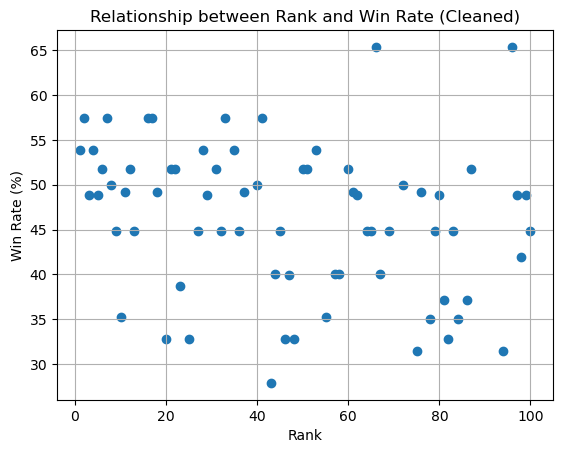

In [84]:
# Show sample rows and row count
print(f"\n Number of valid rows after cleaning: {len(merged_df)}")
display(merged_df[['Rank', 'Win_Rate']].head())

# Scatter plot to visualize the relationship
import matplotlib.pyplot as plt

plt.scatter(merged_df['Rank'], merged_df['Win_Rate'])
plt.xlabel('Rank')
plt.ylabel('Win Rate (%)')
plt.title('Relationship between Rank and Win Rate (Cleaned)')
plt.grid(True)
plt.show()


### Step 10: Display Final Cleaned Data and Scatter Plot

After ensuring that both `Rank` and `Win_Rate` are numeric and free from missing or zero values, we display:

- A scatter plot to visualize the relationship between world ranking and win rate.
- The first few rows of the final cleaned dataset used for the analysis.

This step helps verify data integrity and validate trends through visualization.


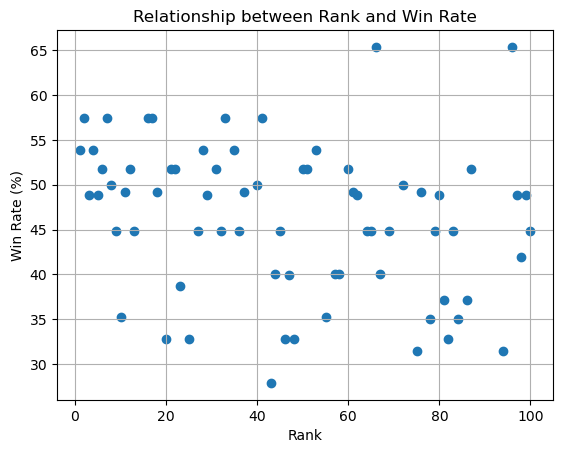

 Number of rows in merged_df:： 70


,Rank,Points,Tournaments,Name,Nationality,Win_Rate
0,1,98715,14,Axelsen Viktor,denmark,53.830334
1,4,83594,19,Antonsen Anders,denmark,53.830334
2,28,47779,17,Gemke Rasmus,denmark,53.830334
3,35,39910,22,Johannesen Magnus,denmark,53.830334
4,53,32423,18,Christophersen Mads,denmark,53.830334


In [87]:
# Scatter plot to visualize the relationship
import matplotlib.pyplot as plt

plt.scatter(merged_df['Rank'], merged_df['Win_Rate'])
plt.xlabel('Rank')
plt.ylabel('Win Rate (%)')
plt.title('Relationship between Rank and Win Rate')
plt.grid()
plt.show()

print(" Number of rows in merged_df:：", len(merged_df))
display(merged_df.head())


In [70]:
# Save the cleaned and merged dataset
merged_df.to_csv('cleaned_badminton_data.csv', index=False)



## Step 11: Preview Final Dataset

We display the number of rows, columns, and a few sample records in the final cleaned and merged dataset.


In [72]:
print("Number of rows in merged_df:", merged_df.shape[0])
print("Number of columns in merged_df:", merged_df.shape[1])
print("Sample rows from merged_df:")
display(merged_df.head())


Number of rows in merged_df: 70
Number of columns in merged_df: 6
Sample rows from merged_df:


,Rank,Points,Tournaments,Name,Nationality,Win_Rate
0,1,98715,14,Axelsen Viktor,denmark,53.830334
1,4,83594,19,Antonsen Anders,denmark,53.830334
2,28,47779,17,Gemke Rasmus,denmark,53.830334
3,35,39910,22,Johannesen Magnus,denmark,53.830334
4,53,32423,18,Christophersen Mads,denmark,53.830334


## Step 12: Check Nationality Inconsistencies

We compare the unique values of the `Nationality` column in both datasets to identify any formatting or spelling inconsistencies that may affect the merge.


In [74]:
print("Unique Nationalities in flashscore_df:")
print(flashscore_df['Nationality'].unique())

print("\nUnique Nationalities in win_rate_df:")
print(win_rate_df['Nationality'].unique())


Unique Nationalities in flashscore_df:
['denmark' 'china' 'indonesia' 'japan' 'thailand' 'india' 'singapore'
 'malaysia' 'hong kong' 'taiwan' 'france' 'canada' 'guatemala' 'belgium'
 'ireland' 'brazil' 'netherlands' 'south korea' 'israel' 'czech republic'
 'el salvador' 'finland' 'azerbaijan' 'spain' 'kazakhstan' 'italy'
 'ukraine' 'sri lanka' 'mexico' 'usa' 'vietnam' 'germany' 'norway'
 'austria' 'nigeria' 'england']

Unique Nationalities in win_rate_df:
['australia' 'austria' 'belgium' 'brazil' 'bulgaria' 'canada' 'china'
 'chinesetaipei' 'czechrepublic' 'denmark' 'egypt' 'england' 'estonia'
 'finland' 'france' 'germany' 'hongkong' 'india' 'indonesia' 'ireland'
 'israel' 'italy' 'japan' 'korea' 'malaysia' 'mauritius' 'mexico'
 'netherlands' 'newcaledonia' 'newzealand' 'pakistan' 'philippines'
 'poland' 'russia' 'scotland' 'singapore' 'spain' 'sweden' 'switzerland'
 'thailand' 'ukraine' 'usa' 'vietnam']


## Step 13: Standardize Nationality Values

To ensure successful merging, we remove leading/trailing spaces and convert all country names to lowercase.


In [76]:
# Remove leading/trailing spaces and convert to lowercase
flashscore_df['Nationality'] = flashscore_df['Nationality'].str.strip().str.lower()
win_rate_df['Nationality'] = win_rate_df['Nationality'].str.strip().str.lower()

# Display unique values again to confirm
print("After Standardization - Unique Nationalities in flashscore_df:")
print(flashscore_df['Nationality'].unique())

print("\nAfter Standardization - Unique Nationalities in win_rate_df:")
print(win_rate_df['Nationality'].unique())


After Standardization - Unique Nationalities in flashscore_df:
['denmark' 'china' 'indonesia' 'japan' 'thailand' 'india' 'singapore'
 'malaysia' 'hong kong' 'taiwan' 'france' 'canada' 'guatemala' 'belgium'
 'ireland' 'brazil' 'netherlands' 'south korea' 'israel' 'czech republic'
 'el salvador' 'finland' 'azerbaijan' 'spain' 'kazakhstan' 'italy'
 'ukraine' 'sri lanka' 'mexico' 'usa' 'vietnam' 'germany' 'norway'
 'austria' 'nigeria' 'england']

After Standardization - Unique Nationalities in win_rate_df:
['australia' 'austria' 'belgium' 'brazil' 'bulgaria' 'canada' 'china'
 'chinesetaipei' 'czechrepublic' 'denmark' 'egypt' 'england' 'estonia'
 'finland' 'france' 'germany' 'hongkong' 'india' 'indonesia' 'ireland'
 'israel' 'italy' 'japan' 'korea' 'malaysia' 'mauritius' 'mexico'
 'netherlands' 'newcaledonia' 'newzealand' 'pakistan' 'philippines'
 'poland' 'russia' 'scotland' 'singapore' 'spain' 'sweden' 'switzerland'
 'thailand' 'ukraine' 'usa' 'vietnam']


## Step 14: Re-Merge After Standardization

After ensuring consistent formatting of the `Nationality` column, we perform the merge again to maximize matches between the two datasets.


In [95]:
# Re-merge datasets
merged_df = pd.merge(flashscore_df, win_rate_df, on='Nationality', how='inner')
print("Number of rows in merged_df after re-merge:", merged_df.shape[0])
display(merged_df.head())

print(f"Rows before merge: {len(flashscore_df)}, after merge: {len(merged_df)}")


Number of rows in merged_df after re-merge: 77


,Rank,Points,Tournaments,Name,Nationality,Win_Rate
0,1,98715,14,Axelsen Viktor,denmark,53.830334
1,4,83594,19,Antonsen Anders,denmark,53.830334
2,28,47779,17,Gemke Rasmus,denmark,53.830334
3,35,39910,22,Johannesen Magnus,denmark,53.830334
4,53,32423,18,Christophersen Mads,denmark,53.830334


Rows before merge: 100, after merge: 77


### Step 15: Identify Merge Issues

After re-merging the datasets, we check which nationalities were not successfully matched between the two datasets.
This helps identify data quality issues such as naming inconsistencies, uncommon country entries, or missing values.

- The first list shows countries in `flashscore_df` that are **not present** in the win rate data.
- The second list shows countries in `win_rate_df` that are **not found** in the top 100 player rankings.



In [98]:
# Nationalities in flashscore_df but not in win_rate_df
unmatched_nationalities = flashscore_df[~flashscore_df['Nationality'].isin(win_rate_df['Nationality'])]
print("Unmatched Nationalities from flashscore_df:")
display(unmatched_nationalities)

# Nationalities in win_rate_df but not in flashscore_df
unmatched_nationalities_2 = win_rate_df[~win_rate_df['Nationality'].isin(flashscore_df['Nationality'])]
print("\nUnmatched Nationalities from win_rate_df:")
display(unmatched_nationalities_2)


Unmatched Nationalities from flashscore_df:


,Rank,Points,Tournaments,Name,Nationality
13,14,63499,27,Lee Cheuk Yiu,hong kong
14,15,62498,31,Chou Tien Chen,taiwan
18,19,57286,30,Lin Chun-Yi,taiwan
23,24,52710,29,Wang Tzu Wei,taiwan
25,26,49856,26,Ng Ka Long Angus,hong kong
29,30,44480,24,Su Li Yang,taiwan
33,34,40138,28,Lee Chia Hao,taiwan
37,38,37616,21,Chi Yu Jen,taiwan
38,39,35776,15,Cordon Kevin,guatemala
48,49,33309,21,Jeon Hyeok Jin,south korea



Unmatched Nationalities from win_rate_df:


,Nationality,Win_Rate
0,australia,20.312500
4,bulgaria,33.333333
7,chinesetaipei,40.346683
8,czechrepublic,0.000000
10,egypt,0.000000
12,estonia,0.000000
16,hongkong,41.501294
23,korea,54.217791
25,mauritius,0.000000
28,newcaledonia,0.000000


## Step 16: Final Correlation Analysis

After cleaning, standardizing, and re-merging both datasets, we perform a final correlation analysis  
between players' world rankings and their average win rates.

This step helps us:
- Confirm whether a statistically meaningful relationship exists between rank and performance
- Understand the impact of previous data cleaning steps on our analytical results

We use the Pearson correlation coefficient, which measures the linear relationship between the two variables.


In [29]:
# Recalculate correlation
correlation = merged_df[['Rank', 'Win_Rate']].corr()
print("Correlation between Rank and Win Rate:")
print(correlation)


Correlation between Rank and Win Rate:
              Rank  Win_Rate
Rank      1.000000 -0.332252
Win_Rate -0.332252  1.000000


### Step 17: Regression Analysis - Rank vs. Win Rate

We use a regression plot to examine the linear relationship between player world ranking and win rate. The plot below shows a negative slope, suggesting that players with higher world rankings (i.e., lower rank values) generally tend to have higher win rates.


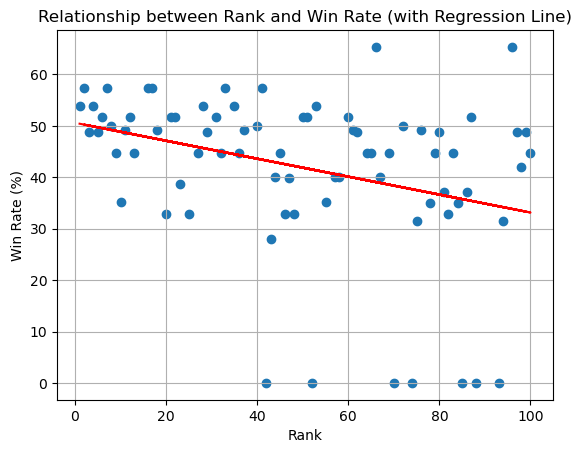

In [102]:
import numpy as np

# Fit a linear regression line
m, b = np.polyfit(merged_df['Rank'], merged_df['Win_Rate'], 1)
plt.scatter(merged_df['Rank'], merged_df['Win_Rate'])
plt.plot(merged_df['Rank'], m * merged_df['Rank'] + b, color='red')
plt.xlabel('Rank')
plt.ylabel('Win Rate (%)')
plt.title('Relationship between Rank and Win Rate (with Regression Line)')
plt.grid()
plt.show()


### Step 18: Distribution of Win Rate

To understand the overall distribution of player win rates, we create a histogram. Most players fall between 30% and 50%, with a notable peak around 50%. A small group has very low win rates, close to 0%. This histogram shows a right-skewed distribution, with most players winning around 40–50%.



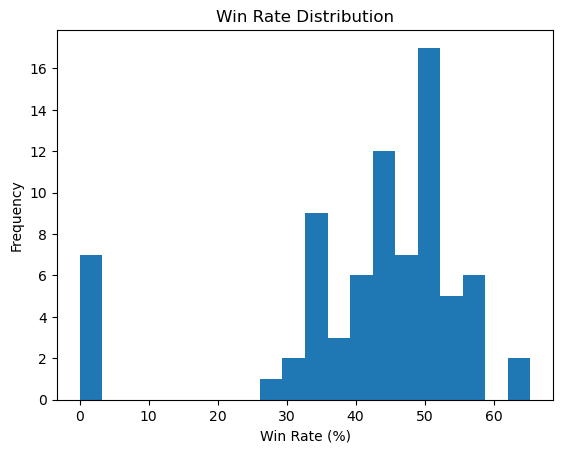

In [105]:
merged_df['Win_Rate'].hist(bins=20)
plt.title('Win Rate Distribution')
plt.xlabel('Win Rate (%)')
plt.ylabel('Frequency')
plt.grid()
plt.show()


### Step 19: R-squared Evaluation

We calculate the R-squared value to quantify how much of the variance in win rate can be explained by player ranking. An R-squared value of around 0.11 indicates that only 11% of the variance is accounted for by ranking, suggesting that other factors likely play a larger role in determining performance.




In [32]:
import numpy as np

# Calculate R-squared value
residuals = merged_df['Win_Rate'] - (m * merged_df['Rank'] + b)
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((merged_df['Win_Rate'] - merged_df['Win_Rate'].mean()) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.2f}")


R-squared: 0.11


### Step 20: Win Rate by Nationality

We visualize the distribution of win rates across different countries using a boxplot. This helps reveal which countries have consistently higher or lower win rates.

- Spain, China, and Denmark top the list, indicating strong player performance.
- These insights may inform training strategies or reveal structural advantages.


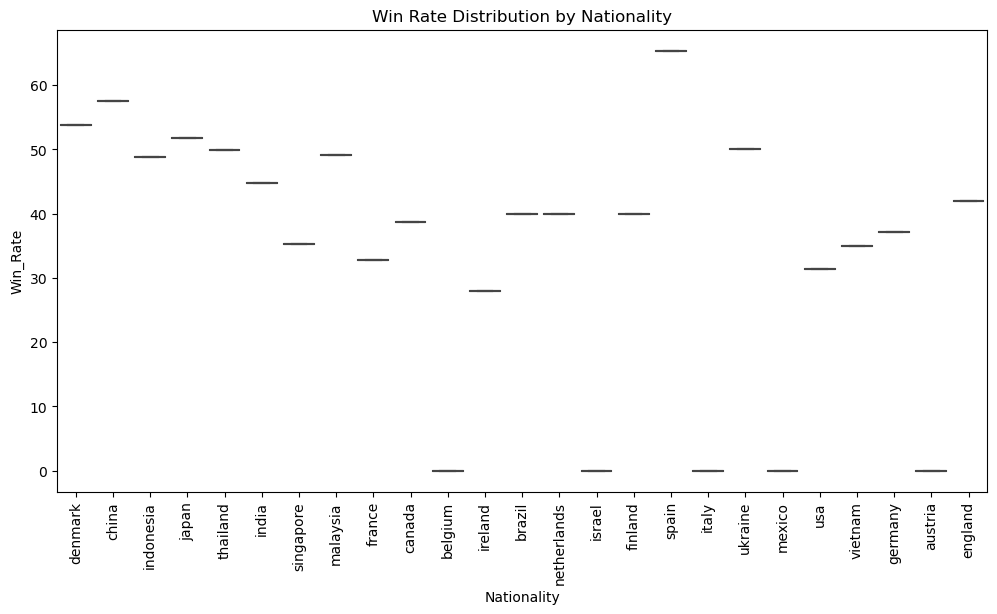

In [110]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='Nationality', y='Win_Rate')
plt.xticks(rotation=90)
plt.title('Win Rate Distribution by Nationality')
plt.show()


### Step 20: Top 5 Nationalities by Average Win Rate

We calculate the average win rate by nationality and display the top 5 countries. This provides insight into which countries tend to have the strongest overall performance in the BWF Super Series dataset.


In [34]:
avg_win_rate_by_country = merged_df.groupby('Nationality')['Win_Rate'].mean().sort_values(ascending=False).head(5)
print("Top 5 Nationalities by Average Win Rate:")
print(avg_win_rate_by_country)


Top 5 Nationalities by Average Win Rate:
Nationality
spain      65.354331
china      57.458687
denmark    53.830334
japan      51.699764
ukraine    50.000000
Name: Win_Rate, dtype: float64
